# Catboosting SBI classification

## Libraries, functions and dictionaries

In [68]:
import sys, os

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import random
import seaborn as sns
import re
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from Bio.PDB.DSSP import make_dssp_dict

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from catboost.datasets import titanic
from graphviz import Digraph

import warnings
warnings.filterwarnings('ignore')

In [6]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

alphabetAA_to_classes={'A':1,'C':2,'D':3,'E':3,'F':1,'G':4,'H':3,'I':1,'K':3,'L':1,'M':1,'N':2,'P':4,'Q':2,'R':3,'S':2,'T':2,'V':1,'W':1,'Y':1}
alphabetclasses_to_AA={v: k for k,v in alphabetAA_to_classes.items()}

AA_ddsp_number={'H' :0,'B' : 1,'E' : 2,'G' : 3,'I' : 4,'T' : 5,'S' : 6,' ' : 7}
AA_number_ddsp={v: k for k,v in AA_ddsp_number.items()}

AA_ddsp_number_simp={'H' :0,'E' : 1,'C' : 2}
AA_number_ddsp_simp={v: k for k,v in AA_ddsp_number.items()}

AA_to_hydrophobicity_scores={'A':44,'C':50,'D':-37,'E':-12,'F':96,'G':0,'H':-16,'I':100,'K':-30,'L':99,'M':74,'N':-35,'P':-46,'Q':-14,'R':-20,'S':-6,'T':13,'V':78,'W':90,'Y':57}

### Load functions

In [7]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [8]:
def load_data_V2(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][len(mutation_load[i])-1]!= '*' :
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

### General functions

In [9]:
def normalize_score(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.percentile(scores[~np.isnan(scores)],5)
    c_max_act=np.percentile(scores[~np.isnan(scores)],95)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [10]:
def normalize_minmax(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.amin(scores[~np.isnan(scores)])
    c_max_act=np.amax(scores[~np.isnan(scores)])
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [11]:
def normalize_fermi(scores):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=1/(sp.exp(scores[i,j]-2)+1)                 
    return normalized_scores

In [12]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [13]:
def position_mean(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        count=0
        flag_nan=True
        for j in range(score.shape[1]):
            if np.isnan(score[i,j])==False:
                flag_nan=False
                score_mean[i]+=score[i,j]
                count+=1
            else:
                pass
        if flag_nan==True:
            score_mean[i]=np.nan
        score_mean[i]/=count
        
    return score_mean

In [14]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):

    counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_unstable=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_unstable+=counts[i]
    print('Wt-like variants:',np.sum(counts)-sum_unstable, ' (', (np.sum(counts)-sum_unstable)/np.sum(counts) ,')')
    
    #plt.show()

In [15]:
def heatmap_IBS(prediction,variant_map,WT):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    
    ax.imshow(np.transpose(scores), aspect = 'auto', cmap=mpl.colors.ListedColormap(["white","#56b4e9"]))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels,fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)
        
    tmp=np.empty((len(WT),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT)):
        tmp[i,alphabetAA_L_D[WT[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')
    
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation",fontsize=16)
    plt.xlabel("residue",fontsize=16)

    plt.ylim(-0.5,19.5)

In [16]:
def ratio_variants(mave_funct,mave_abd):
    ratio=np.copy(mave_funct)
    ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(mave_funct[i,j]) or np.isnan(mave_abd[i,j]):
                pass
            else:
                if mave_abd[i,j]==0.0:
                    ratio[i,j]=mave_funct[i,j]/0.0000001
                else:
                    ratio[i,j]=mave_funct[i,j]/mave_abd[i,j]
    sig_ratio=np.copy(ratio)
    sig_ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(ratio[i,j])!=True:
                sig_ratio[i,j]=1/(1+np.exp(-(ratio[i,j]-1)))

    return sig_ratio

In [17]:
def MCC_test_subset(prediction,test):
    TP=0
    FP=0
    total=0
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if int(test[i])==1:
                total+=1
    precision=TP/(TP+FP)
    recall=TP/total
    mcc=np.sqrt(abs(precision*recall))
    
    return precision,recall,mcc                 

In [18]:
def AUC_subset(prediction,test):
    TP=0
    FP=0
    FN=0
    TN=0
    
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if prediction[i]==0:
                if int(prediction[i])==int(test[i]):
                    TN+=1
                else:
                    FN+=1 
                    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    
    return [TPR,FPR]

In [19]:
def retrieve_residue_label_pred_training(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage_mode=np.zeros((len(WT),2),dtype=float)
    
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            count_1=0
            for j in range(scores.shape[1]):
                if scores[i,j]==1:
                    count_1+=1
            percentage=count_1/count
            
            if percentage > percentage_threshold:
                pseudomode_value_class[i]=1
            else:
                pseudomode_value_class[i]=0
            
            percentage_mode[i,0]=percentage
            percentage_mode[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage_mode

In [20]:
def retrieve_residue_label_pred(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    
    count_pos=np.zeros((len(WT),4),dtype=float)
    
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage=np.zeros((len(WT),2),dtype=float)
        
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            for j in range(scores.shape[1]):
                    if np.isnan(scores[i,j])!=True:
                        count_pos[i,int(scores[i,j])]+=1
            count_pos=count_pos/count
            if np.any(count_pos[i,:]>=0.50):
                pseudomode_value_class[i]=np.argmax(count_pos[i,:])
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),pseudomode_value_class[i])


            else:                
                pseudomode_value_class[i]=5
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),'else',pseudomode_value_class[i])
                ## 5 indicates mixed signal with no predominat mutation class
            
            percentage[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage

In [21]:
def print_chimera_x_attribute_file(attribute_check,attribute,file,model_id='#1',chain_id='/A',argument='cbyvalue'):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s%s\n%s\n%s\n' % ( 'attribute: ',argument,'match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True or attribute_check[i]==-99999:
            pass
        else:
            file.write("\t%s%s%s%d\t%f\n" % (str(model_id),str(chain_id),':',i+1,attribute[i]))
    file.close()

In [22]:
def plot_attributes(pos,pred,variant_map,gemme,rosetta,wcn,gemme_n,rosetta_n):
    
    label_position=np.empty(20,dtype=float)
    label_position[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            label_position[cord[1]]=prediction[i]
        i+=1
    
    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(9,4),gridspec_kw={"width_ratios" : [7,1,1,1,1,1], "wspace" : 0.4})
    cdict = {1: 'blue', 0: 'red'}
    glabel={1.0:'SBI',0.0:'non-SBI'}
    for g in np.unique(label_position):
        if np.isnan(g)!=True:
            ix = np.where(label_position == g)
            ax1.scatter(rosetta[pos,ix],gemme[pos,ix],c=cdict[g], label=[glabel[g]])
    
    ax2.bar(x=0.5,height=wcn[pos])
    ax3.bar(x=0.5,height=np.mean(gemme[pos,:][~np.isnan(gemme[pos,:])]))
    ax4.bar(x=0.5,height=np.mean(rosetta[pos,:][~np.isnan(rosetta[pos,:])]))   
    ax5.bar(x=0.5,height=gemme_n[pos])
    ax6.bar(x=0.5,height=rosetta_n[pos])
    
    
    ax1.set_title('variants classification')
    ax2.set_title('WCN')
    ax3.set_title(r'$\bar{G}$')
    ax4.set_title(r'$\bar{r}$')
    ax5.set_title(r'G_n')
    ax6.set_title(r'r_n')
    
    ax1.set_xlabel('rosetta_score',fontsize=13)
    ax1.set_ylabel('GEMME score',fontsize=13)
    ax1.set_xlim(6,-1)
    ax1.set_ylim(-7,1)
    ax2.set_ylim(0,15)
    ax3.set_ylim(0,-8)
    ax4.set_ylim(0,6)
    ax5.set_ylim(0,-8)
    ax6.set_ylim(0,6)
    
    
    ax2.set_xticks([],[])
    ax3.set_xticks([],[])
    ax4.set_xticks([],[])
    ax5.set_xticks([],[])
    ax6.set_xticks([],[])
    ax2.set_xlim(0.1,0.9)
    
    
    
    ax1.legend()

In [23]:
def results_plot(MCC,AUC,name_models):
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,4))
    
    cdict = {1: '#355070', 2: '#6D597A',2:'#B56576',3 :'#a4d600',4:'#a47f4b',5:'#EAAC8B',6:'#4a944f',7:"#F95738"}
    for g in range(0,7):
        ax1.scatter(AUC[g,1],AUC[g,0],c=cdict[g+1])
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes,ls=':')
    ax1.set_xlabel('FPR',fontsize=13)
    ax1.set_ylabel('TPR',fontsize=13)
    
    for g in range(0,7):
        ax2.scatter(MCC[g,0],MCC[g,1],c=cdict[g+1], label=g+1)
    #ax2.scatter(MCC[:,0],MCC[:,1],c=color_class)
    
    ax2.set_xlabel('Precision',fontsize=13)
    ax2.set_ylabel('Recall',fontsize=13)
    ax2.legend(loc='lower right')
    
    cbar=[cdict[i] for i in range(1,8)]
    ax3.bar(name_models,MCC[:,2],color=cbar)
    ax3.set_ylabel('MCC',fontsize=13)


In [24]:
def print_percentage_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    print(f' SBI variants: {count_SBI} out of {len(pred)} ({count_SBI/len(pred)*100:.2f}%) ')
    
    perc_variants=count_SBI/len(pred)*100
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    print(f' SBI residues: {count_SBI} out of {effective_pos} ({count_SBI/effective_pos*100:.2f}%) ')
    
    return [perc_variants, count_SBI/effective_pos*100]

In [25]:
def print_numbers_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    variants=count_SBI
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    
    return [variants, count_SBI]

In [26]:
def print_numbers_classification(pred,mode_pred):

    count_SBI=[0,0,0,0]
    for i in pred:
            count_SBI[int(i)]+=1
    
    variants=count_SBI
    
    count_SBI=[0,0,0,0,0]
    for i in mode_pred:
        if np.isnan(i)!=True:
            if i==5:
                count_SBI[4]+=1
            else:
                count_SBI[int(i)]+=1
    
    return [variants, count_SBI]

In [27]:
def print_catalytic_classification(mode_pred,cat_positions):
    cat_pos=[x - 1 for x in cat_positions]
    cat_pos=np.array(cat_pos)
    count_SBI=[0,0,0,0,0]

    for i,n in enumerate(mode_pred):
        if np.count_nonzero(cat_pos == i)==1:
            if np.isnan(i)!=True:
                if int(n)==5:
                    count_SBI[4]+=1
                else:
                    count_SBI[int(n)]+=1
    
    return  count_SBI

### setup ML functions

In [28]:
def WCN(pdb_loc,scheme_e,WT):
    r0=7.0
    pdb=md.load(pdb_loc)
    topology=pdb.topology
    chainA=topology.select('chainid 0 and protein')
    pdb_chain0=pdb.atom_slice(chainA)
    pdb_dist,pdb_rp=md.compute_contacts(pdb_chain0,scheme=scheme_e,periodic=False)
    
    cm= md.geometry.squareform(pdb_dist,pdb_rp)[0]
    wcn=np.zeros((len(WT)),dtype=float)
    
    cm_adj=np.empty((len(WT),len(WT)),dtype=float)
    cm_adj[:]=np.nan
    chainA_top=pdb_chain0.topology
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i==0 and j==0:
                print(str(chainA_top.residue(i)))
            cm_adj[int(str(chainA_top.residue(i))[3:])-1,int(str(chainA_top.residue(j))[3:])-1]=cm[i,j]
    for i in range(len(WT)):
        nan_flag=True
        for j in range(len(WT)):
            if np.isnan(cm_adj[i,j])!=True and cm_adj[i,j]!=0.0:
                nan_flag=False
                wcn[i]+=(1-(cm_adj[i,j]*10/r0)**6)/(1-(cm_adj[i,j]*10/r0)**12)
        if nan_flag==True:
            wcn[i]=np.nan
    return wcn

In [29]:
def neighbor_scores(score,ext_range):
    score_neighborhood=np.zeros(len(score),dtype=float)
    for i in range(len(score)):
        if np.isnan(score[i])!=True:
            count_nan=0
            if i==0:
                for j in range(1,ext_range+1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range:    
                    score_neighborhood[i]/=(ext_range)
                else:
                    score_neighborhood[i]=np.nan

            elif i==(len(score)-1):
                for j in range(len(score)-1-ext_range,len(score)-1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range: 
                    score_neighborhood[i]/=ext_range
                else:
                    score_neighborhood[i]=np.nan                
            elif i<ext_range:
                for j in range(0,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(i+ext_range):    
                    score_neighborhood[i]/=(i+ext_range)
                else:
                    score_neighborhood[i]=np.nan                        

            elif i>(len(score)-1-ext_range):
                for j in range(i-ext_range,len(score)):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(len(score)-i+ext_range):                     
                    score_neighborhood[i]/=(len(score)-i+ext_range)
                else:
                    score_neighborhood[i]=np.nan  
            else:
                for j in range(i-ext_range,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(2*ext_range):  
                    score_neighborhood[i]/=(2*ext_range)
                else:
                    score_neighborhood[i]=np.nan             
        else:
            score_neighborhood[i]=np.nan
    return score_neighborhood

In [30]:
def label_category(output,threshold):
    labels=[]
    if output.ndim==1:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(len(output)):
            if output[i]<threshold:
                labels[i]=0
            else:
                labels[i]=1
    else:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i,j]<threshold:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    return labels

In [31]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [32]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [33]:
def features_validation(list_features_x,WT):
    
    X=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
            

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    mapping_pos.append([i,j])
        
    return np.array(X),mapping_pos        

In [34]:
def binary_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    
    return labels

In [35]:
def multiclass_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                elif data_x[i,j] < t_x and data_y[i,j]<t_y:
                    labels[i,j]=2
                elif data_x[i,j] < t_x and data_y[i,j]>t_y:
                    labels[i,j]=3
                else:
                    labels[i,j]=0
    
    return labels

In [36]:
def prob_to_label(probability,thr):
    labels=np.zeros(probability.shape[0],dtype=int)
    for i in range(probability.shape[0]):
        if probability[i][1]>thr:
            labels[i]=1
            #print(1)
        else:
            labels[i]=0
            #print(0)
    return labels

In [69]:
def modify_dssp(protein,dssp_data,sequence,pdb_chain='A'):

    """
    Read the dictionary output from Biopython function Bio.PDB.DSSP.make_dssp_dict,
    and put relevant DSSP data (i.e. the secondary structure and  ASA) into a DataFrame.
    Remove data for residues that do not occur in the UniProt sequences of the proteins (e.g.
    residues added or mutated for experimental/purification reasons).
    """

    # get relevant data from make_dssp_dict dictionary
    dssp_dict = {}
    for res in list(dssp_data[0].keys()):
        if res[0] == pdb_chain: # select only from specified chain
            dssp_dict[res[1][1]] = list(dssp_data[0][res][0:3]) # extract only SS and ASA

    # create DataFrame with the selected DSSP output
    df_dssp_raw = pd.DataFrame.from_dict(dssp_dict,orient='index',columns=['PDB_res','ss','ASA',])

    # create DataFrame with UniProt sequence data
    uniprot_seq = dict(zip(range(1,len(sequence)+1),sequence))
    df_seq = pd.DataFrame.from_dict(uniprot_seq,orient='index',columns=['Sequence'])

    # remove data for residues (residue indices) not present in UniProt sequences
    for i in np.array(df_dssp_raw.index):
        if i not in np.array(df_seq.index):
            print(str(i)+str(df_dssp_raw.loc[i][0])+' will be removed')
            df_dssp_raw.drop([i],inplace=True)

    # remove data for residues not matching the residues in the UniProt sequence (within the sequence)
    if np.all(df_dssp_raw['PDB_res'] == df_seq['Sequence'].loc[df_dssp_raw['PDB_res'].index]):
        df_dssp_final = pd.concat([df_seq,df_dssp_raw],axis=1)
    else:
        mismatch = list(df_dssp_raw['PDB_res'][df_dssp_raw['PDB_res'] !=
                                               df_seq['Sequence'].loc[df_dssp_raw['PDB_res'].index]].index)
        print(mismatch)
        print('Sequences do not match, residue(s) {} will be removed'.format(str(mismatch)))
        df_dssp_raw.drop(mismatch,inplace=True)
        df_dssp_final = pd.concat([df_seq,df_dssp_raw],axis=1)

    # add relative ASA to final DataFrame

    # maxASA from doi:10.1371/journal.pone.0080635
    maxASA = {'A':129.0, 'R':274.0, 'N':195.0, 'D':193.0, 'C':167.0, 'E':223.0, 'Q':225.0, 'G':104.0,
              'H':224.0, 'I':197.0, 'L':201.0, 'K':236.0, 'M':224.0, 'F':240.0, 'P':159.0, 'S':155.0,
              'T':172.0, 'W':285.0, 'Y':263.0, 'V':174.0}

    # calculate and add rASAs to df_dssp_final
    rASA_list = []
    for i in df_dssp_final.index:
        res_type = df_dssp_final['Sequence'].loc[i]
        rASA = (df_dssp_final['ASA'].loc[i])/(maxASA[res_type])
        rASA_list.append(rASA)
    df_dssp_final['rASA'] = rASA_list

    return df_dssp_final
            

## Load trained model

In [37]:
cat=CatBoostClassifier(iterations=2500, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1})

In [38]:
cat.load_model('../catboost_model/cat_trained_24jun22.cbm')

## Load validation dataset

In [39]:
P0A7E3_WT_sequence="MKPYQRQFIEFALSKQVLKFGEFTLKSGRKSPYFFNAGLFNTGRDLALLGRFYAEALVDSGIEFDLLFGPAYKGIPIATTTAVALAEHHDLDLPYCFNRKEAKDHGEGGNLVGSALQGRVMLVDDVITAGTAIRESMEIIQANGATLAGVLISLDRQERGRGEISAIQEVERDYNCKVISIITLKDLIAYLEEKPEMAEHLAAVKAYREEFGV"
P0A7E3_WT_seq_rose="MKPYQRQFIEFALSKQVLKFGEFTLKSGRKSPYFFNAGLFNTGRDLALLGRFYAEALVDSGIEFDLLFGPAYKGIPIATTTAVALAEHHDLDLPYCFNRKEAKDHGEGGNLVGSALQGRVMLVDDVITAGTAIRESMEIIQANGATLAGVLISLDRQERGRGEISAIQEVERDYNCKVISIITLKDLIAYLEEKPEMAEHLAAVKAYREEFGV"

In [40]:
count=0
for i in range(len(P0A7E3_WT_sequence)):
    if P0A7E3_WT_sequence[i]==P0A7E3_WT_seq_rose[i]:
        count+=1
print(len(P0A7E3_WT_sequence),count/len(P0A7E3_WT_seq_rose))

213 1.0


#### P0A7E3 active site

In [41]:
P0A7E3_db_positions=[103,105]

#### Co-evolution

In [43]:
P0A7E3_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P0A7E3.txt',P0A7E3_WT_sequence)
P0A7E3_GEMME=remove_WT_score(P0A7E3_GEMME,P0A7E3_WT_sequence)

In [44]:
P0A7E3_GEMME_mean=position_mean(P0A7E3_GEMME)

####  Rosetta ddG

In [50]:
P0A7E3_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P0A7E3.txt",P0A7E3_WT_seq_rose)
P0A7E3_rosetta_ddg=remove_WT_score(P0A7E3_rosetta_ddg,P0A7E3_WT_seq_rose)

In [51]:
P0A7E3_rosetta_ddg_norm=normalize_cutoff(P0A7E3_rosetta_ddg,0.0,5.0)

In [52]:
P0A7E3_rosetta_ddg_mean=position_mean(P0A7E3_rosetta_ddg_norm)

In [54]:
P0A7E3_rosetta_dimer_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P0A7E3_dimer.txt",P0A7E3_WT_seq_rose)
P0A7E3_rosetta_dimer_ddg=remove_WT_score(P0A7E3_rosetta_dimer_ddg,P0A7E3_WT_seq_rose)
P0A7E3_rosetta_dimer_ddg/=2

In [55]:
P0A7E3_rosetta_dimer_ddg_norm=normalize_cutoff(P0A7E3_rosetta_dimer_ddg,0.0,5.0)

In [56]:
P0A7E3_rosetta_dimer_ddg_mean=position_mean(P0A7E3_rosetta_dimer_ddg_norm)

#### Hydrophobicity

In [57]:
P0A7E3_hydrophobicity_mut=np.empty((len(P0A7E3_WT_sequence),20),dtype=float)
P0A7E3_hydrophobicity_mut[:]=np.nan

In [58]:
for i in range(len(P0A7E3_WT_sequence)):
    for j in range(20):
        P0A7E3_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [60]:
P0A7E3_wcn=WCN('../pdbs/P0A7E3_1oro.pdb','ca',P0A7E3_WT_sequence)

MET1


In [61]:
P0A7E3_wcn_dimer_double=WCN('../pdbs/P0A7E3_1oro_dimer.pdb','ca',P0A7E3_WT_sequence+P0A7E3_WT_sequence)

MET1


In [62]:
P0A7E3_wcn_dimer=P0A7E3_wcn_dimer_double[0:len(P0A7E3_WT_sequence)]

#### Neighbor sequences scores:

In [63]:
P0A7E3_rosetta_neigbor_scores=neighbor_scores(P0A7E3_rosetta_ddg_mean,1)

P0A7E3_GEMME_neigbor_scores=neighbor_scores(P0A7E3_GEMME_mean,1)

P0A7E3_rosetta_dimer_neigbor_scores=neighbor_scores(P0A7E3_rosetta_dimer_ddg_mean,1)

## Predictions

### P0A7E3 Validation

#### monomer

In [183]:
P0A7E3_X,P0A7E3_map=features_validation([P0A7E3_GEMME, P0A7E3_rosetta_ddg_norm,P0A7E3_GEMME_mean,P0A7E3_rosetta_ddg_mean,P0A7E3_hydrophobicity_mut,P0A7E3_GEMME_neigbor_scores,P0A7E3_rosetta_neigbor_scores,P0A7E3_wcn],P0A7E3_WT_sequence)

In [184]:
prediction=cat.predict(P0A7E3_X)

In [185]:
P0A7E3_variant_pred=np.empty((len(P0A7E3_WT_sequence),20),dtype=float)
P0A7E3_variant_pred[:]=np.nan

for i,(n,m) in enumerate(zip(P0A7E3_map,prediction)):
    P0A7E3_variant_pred[n[0],n[1]]=m

In [186]:
P0A7E3_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P0A7E3_map,P0A7E3_WT_sequence,0.5)

In [215]:
print_chimera_x_attribute_file(P0A7E3_3mode_prediction,P0A7E3_3mode_prediction,'./outputs/P0A7E3_chimerax_monomer_fm_predictions.defattr',model_id='#1',chain_id='/A',argument='monomer_classes')

#### dimer

In [187]:
P0A7E3_X,P0A7E3_map=features_validation([P0A7E3_GEMME, P0A7E3_rosetta_dimer_ddg_norm,P0A7E3_GEMME_mean,P0A7E3_rosetta_dimer_ddg_mean,P0A7E3_hydrophobicity_mut,P0A7E3_GEMME_neigbor_scores,P0A7E3_rosetta_dimer_neigbor_scores,P0A7E3_wcn_dimer],P0A7E3_WT_sequence)

In [188]:
prediction=cat.predict(P0A7E3_X)

In [189]:
P0A7E3_variant_dimer_pred=np.empty((len(P0A7E3_WT_sequence),20),dtype=float)
P0A7E3_variant_dimer_pred[:]=np.nan

for i,(n,m) in enumerate(zip(P0A7E3_map,prediction)):
    P0A7E3_variant_dimer_pred[n[0],n[1]]=m

In [190]:
P0A7E3_3mode_dimer_prediction,percentage=retrieve_residue_label_pred(prediction,P0A7E3_map,P0A7E3_WT_sequence,0.5)

In [214]:
print_chimera_x_attribute_file(P0A7E3_3mode_dimer_prediction,P0A7E3_3mode_dimer_prediction,'./outputs/P0A7E3_chimerax_dimer_fm_predictions.defattr',model_id='#1',chain_id='/A',argument='dimer_classes')

## DSSP

In [70]:
monomer_dssp_dict=make_dssp_dict('../scores_dssp/P0A7E3_1oro_monomer.dssp')

In [71]:
dimer_dssp_dict=make_dssp_dict('../scores_dssp/P0A7E3_1oro_dimer.dssp')

In [72]:
P0A7E3_monomer_dssp=modify_dssp('P0A7E3',monomer_dssp_dict,P0A7E3_WT_sequence)

In [73]:
P0A7E3_monomer_dssp

,Sequence,PDB_res,ss,ASA,rASA
1,M,M,-,67,0.299107
2,K,K,-,84,0.355932
3,P,P,H,84,0.528302
4,Y,Y,H,21,0.079848
5,Q,Q,H,13,0.057778
...,...,...,...,...,...
209,E,E,H,163,0.730942
210,E,E,H,126,0.565022
211,F,F,H,26,0.108333
212,G,G,B,13,0.125000


In [74]:
P0A7E3_dimer_dssp=modify_dssp('P0A7E3',dimer_dssp_dict,P0A7E3_WT_sequence)

In [75]:
P0A7E3_dimer_dssp

,Sequence,PDB_res,ss,ASA,rASA
1,M,M,-,67,0.299107
2,K,K,-,84,0.355932
3,P,P,H,84,0.528302
4,Y,Y,H,21,0.079848
5,Q,Q,H,13,0.057778
...,...,...,...,...,...
209,E,E,H,163,0.730942
210,E,E,H,126,0.565022
211,F,F,H,26,0.108333
212,G,G,B,13,0.125000


<BarContainer object of 213 artists>

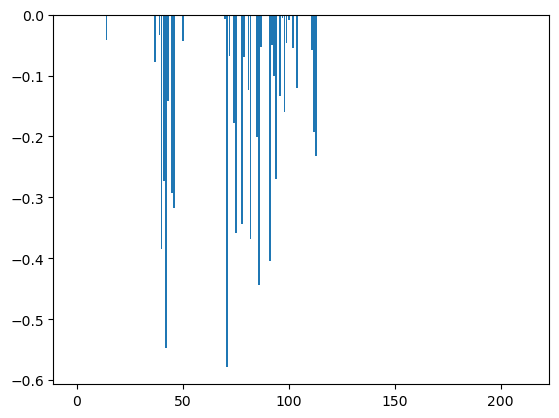

In [76]:
plt.bar(np.arange(0,len(P0A7E3_dimer_dssp['rASA'].to_numpy().flatten()),1), P0A7E3_dimer_dssp['rASA'].to_numpy().flatten()-P0A7E3_monomer_dssp['rASA'].to_numpy().flatten())

In [ ]:
P0A7E3_residue_at_interface=[]
P0A7E3_residue_at_interface_str=''
for i,n in enumerate(P0A7E3_dimer_dssp['rASA'].to_numpy().flatten()-P0A7E3_monomer_dssp['rASA'].to_numpy().flatten()):
    if np.abs(n) >0.1:
        print(str(i+1)+', ',end='')
        P0A7E3_residue_at_interface.append(i)
        P0A7E3_residue_at_interface_str+=(str(i)+' ')

41, 42, 43, 44, 46, 47, 72, 75, 76, 79, 82, 83, 86, 87, 92, 94, 95, 97, 99, 105, 113, 114, 

In [ ]:
P0A7E3_residue_at_interface_binary=np.zeros(len(P0A7E3_WT_sequence),dtype=int)
for i in P0A7E3_residue_at_interface:
    P0A7E3_residue_at_interface_binary[i]=1

In [ ]:
P0A7E3_residue_at_interface_str

'40 41 42 43 45 46 71 74 75 78 81 82 85 86 91 93 94 96 98 104 112 113 '

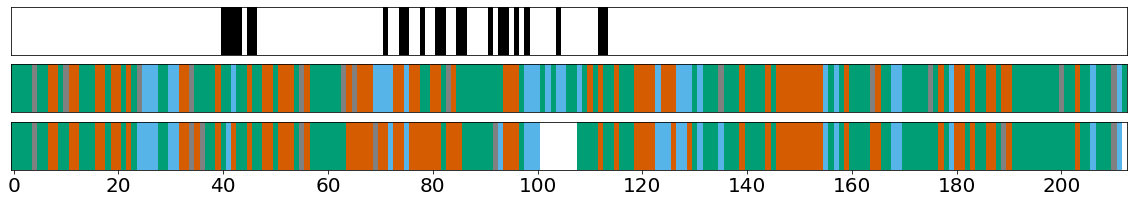

In [ ]:
# Comparison with experimental MAVE residue colour classification
fig, ((ax1),(ax2),(ax3)) = plt.subplots(3,1,figsize=(20,3))

ax1.imshow(np.transpose(P0A7E3_residue_at_interface_binary.reshape(-1,1)),aspect= 'auto', cmap=mpl.colors.ListedColormap(["white", "black"]))
ax1.set_yticks([])
ax1.set_xticks([])
plt.xlim(0-0.5,len(P0A7E3_WT_sequence)-0.5)

ax2.imshow(np.transpose(P0A7E3_3mode_prediction.reshape(-1,1)),aspect= 'auto', cmap=mpl.colors.ListedColormap(["#009e74", "#56b4e9","#d55c00",'gray','gray']))
ax2.set_yticks([])
ax2.set_xticks([])
plt.xlim(0-0.5,len(P0A7E3_WT_sequence)-0.5)

ax3.imshow(np.transpose(P0A7E3_3mode_dimer_prediction.reshape(-1,1)),aspect= 'auto', cmap=mpl.colors.ListedColormap(["#009e74", "#56b4e9","#d55c00",'gray','gray']))
ax3.set_yticks([])
ax3.xaxis.set_ticks(np.arange(0, len(P0A7E3_WT_sequence), 20))
ax3.set_xticklabels(np.arange(0, len(P0A7E3_WT_sequence), 20),fontsize=20)
plt.xlim(0-0.5,len(P0A7E3_WT_sequence)-0.5)

#plt.grid(axis='x',which='both',color='gray', linestyle='-')
plt.savefig('./Figures/P0A7E3_comparison_monomer_dimer.pdf')